In [27]:
import os
import shutil
import pathlib
import functools 
import re
from spellchecker import SpellChecker
import csv

import pandas as pd
import numpy as np
from PIL import Image
import datetime
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
import tensorflow_addons as tfa
import tensorflow_hub as hub
import tensorflow_probability as tfp
from sklearn.model_selection import train_test_split

In [28]:
batch_size = 32
epochs = 5

CLASS_COUNT = 5

IMG_HEIGHT = 224
IMG_WIDTH = 224

AUTOTUNE = tf.data.experimental.AUTOTUNE

# Import data

In [29]:
def load_metadata(furniture_type):
    df = pd.read_csv('./Bonn_Furniture_Styles_Dataset/metadata/{}.txt'.format(furniture_type), sep="\t", names=['style', 'path', 'nan', 'metadata', 'label'])
    df.drop(columns=['style','nan','metadata'], inplace=True)
    df.path = df.path.map(lambda x: './Bonn_Furniture_Styles_Dataset/' + x)
    df.label = furniture_type
    return df
df = functools.reduce(lambda df1, df2: df1.append(df2), list(map(load_metadata, ['beds', 'chairs', 'dressers', 'sofas', 'tables'])))
df.reset_index(inplace=True, drop=True)
df

,path,label
0,./Bonn_Furniture_Styles_Dataset/houzz/beds/Ecl...,beds
1,./Bonn_Furniture_Styles_Dataset/houzz/beds/Ecl...,beds
2,./Bonn_Furniture_Styles_Dataset/houzz/beds/Ecl...,beds
3,./Bonn_Furniture_Styles_Dataset/houzz/beds/Ecl...,beds
4,./Bonn_Furniture_Styles_Dataset/houzz/beds/Ecl...,beds
...,...,...
57677,./Bonn_Furniture_Styles_Dataset/houzz/tables/T...,tables
57678,./Bonn_Furniture_Styles_Dataset/houzz/tables/T...,tables
57679,./Bonn_Furniture_Styles_Dataset/houzz/tables/T...,tables
57680,./Bonn_Furniture_Styles_Dataset/houzz/tables/T...,tables


# Create onehot label

In [30]:
labels = df.label.unique()
labels

array(['beds', 'chairs', 'dressers', 'sofas', 'tables'], dtype=object)

In [31]:
df['label_onehot'] = df.label.apply(lambda x: (labels == x))
df.label_onehot

0        [True, False, False, False, False]
1        [True, False, False, False, False]
2        [True, False, False, False, False]
3        [True, False, False, False, False]
4        [True, False, False, False, False]
                        ...                
57677    [False, False, False, False, True]
57678    [False, False, False, False, True]
57679    [False, False, False, False, True]
57680    [False, False, False, False, True]
57681    [False, False, False, False, True]
Name: label_onehot, Length: 57682, dtype: object

# Split train/test and balance class size for train set

In [32]:
df.groupby(['label']).count()

,path,label_onehot
label,,
beds,6578,6578
chairs,22053,22053
dressers,7871,7871
sofas,4080,4080
tables,17100,17100


In [33]:
TEST_CLASS_SIZE = 2000
TRAIN_CLASS_SIZE = 8000

In [34]:
df_test = functools.reduce(lambda df1, df2: df1.append(df2), list(map(lambda x: df[df.label == x].sample(n=TEST_CLASS_SIZE, random_state=0), ['beds', 'chairs', 'dressers', 'sofas', 'tables'])))
df_test.groupby(['label']).count()

,path,label_onehot
label,,
beds,2000,2000
chairs,2000,2000
dressers,2000,2000
sofas,2000,2000
tables,2000,2000


In [35]:
df_train = df[~df.isin(df_test)]
df_train.groupby('label').count()

,path,label_onehot
label,,
beds,4578,4578
chairs,20053,20053
dressers,5871,5871
sofas,2080,2080
tables,15100,15100


In [36]:
def balance_class_size(label):
    df_len = len(df_train[df_train.label == label])
    n = int(np.ceil(TRAIN_CLASS_SIZE/df_len))
    df_dup = pd.concat([df_train[df_train.label == label]]*n)
    return df_dup.sample(n=TRAIN_CLASS_SIZE)

df_train = functools.reduce(lambda df1, df2: df1.append(df2), list(map(balance_class_size, ['beds', 'chairs', 'dressers', 'sofas', 'tables'])))
df_train.groupby(['label']).count()

,path,label_onehot
label,,
beds,8000,8000
chairs,8000,8000
dressers,8000,8000
sofas,8000,8000
tables,8000,8000


# Mixup and import images

Label:  tf.Tensor([0.8860907  0.11390932 0.         0.         0.        ], shape=(5,), dtype=float32)


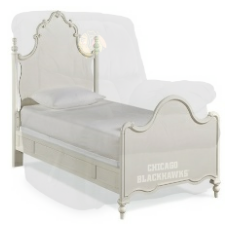

In [37]:
def mixup(sample1, sample2):
    image1, label1 = sample1
    image2, label2 = sample2
    
    dist = tfp.distributions.Beta(0.2, 0.2)
    l = dist.sample(1)

    img = image1*(1-l) + image2*l
    label = tf.cast(label1, tf.float32)*(1-l) + tf.cast(label2, tf.float32)*l
    
    return img, label

ds_test = tf.data.Dataset.from_tensor_slices((df_test.path, np.stack(df_test.label_onehot)))
ds_train = tf.data.Dataset.from_tensor_slices((df_train.path, np.stack(df_train.label_onehot)))

def import_images(path, label):
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)
    img = tf.image.resize(img, [IMG_HEIGHT, IMG_WIDTH])
    return img, tf.convert_to_tensor(label)

ds_test = ds_test.map(import_images)
ds_train_1 = ds_train.shuffle(CLASS_COUNT * TRAIN_CLASS_SIZE).map(import_images)
ds_train_2 = ds_train.shuffle(CLASS_COUNT * TRAIN_CLASS_SIZE).map(import_images)
ds_train = tf.data.Dataset.zip((ds_train_1, ds_train_2)).map(mixup)

for img, label in ds_train.take(1):
    print('Label: ', label)
    plt.imshow(img.numpy())
    plt.axis('off')

Image shape:  (224, 224, 3)
Label:  [0.         0.9174063  0.         0.08259368 0.        ]


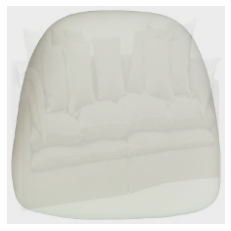

In [38]:
def augment(img, label):
    img = tf.image.random_flip_left_right(img)
    img = tf.image.random_brightness(img, 0.2)
    return img,label

ds_train = ds_train.map(augment).batch(batch_size).prefetch(AUTOTUNE)
ds_test = ds_test.batch(batch_size).prefetch(AUTOTUNE)

for batch in ds_train.take(1):
    img = batch[0][0]
    label = batch[1][0]
    print("Image shape: ", img.numpy().shape)
    print("Label: ", label.numpy())
    plt.imshow(img.numpy())
    plt.axis('off')

# Create model

In [39]:
hub_url = "https://tfhub.dev/google/bit/m-r50x1/1"
feature_extractor_layer = hub.KerasLayer(hub_url, trainable=False)

model = tf.keras.Sequential([
    feature_extractor_layer, 
    tf.keras.layers.Dense(CLASS_COUNT)
])
model.build([None, IMG_HEIGHT, IMG_WIDTH, 3]) 

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     multiple                  23500352  
_________________________________________________________________
dense (Dense)                multiple                  10245     
Total params: 23,510,597
Trainable params: 10,245
Non-trainable params: 23,500,352
_________________________________________________________________


In [72]:
model.compile(
  optimizer=tf.keras.optimizers.SGD(learning_rate=0.003, momentum=0.9),
  loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
  metrics=['acc'])

In [57]:
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath='./furniture_type_weights/weights',
                                                 save_weights_only=True,
                                                 verbose=1)

history = model.fit(
    ds_train,
    validation_data=ds_test,
    epochs=5,
    callbacks=[cp_callback]
)

Epoch 1/5
625/625 [==============================] - ETA: 0s - loss: 1.1188 - acc: 0.8643
Epoch 00001: saving model to ./weights
625/625 [==============================] - 716s 1s/step - loss: 1.1188 - acc: 0.8643 - val_loss: 0.4282 - val_acc: 0.8974
Epoch 2/5
625/625 [==============================] - ETA: 0s - loss: 0.8057 - acc: 0.8814
Epoch 00002: saving model to ./weights
625/625 [==============================] - 288s 461ms/step - loss: 0.8057 - acc: 0.8814 - val_loss: 0.1637 - val_acc: 0.9526
Epoch 3/5
625/625 [==============================] - ETA: 0s - loss: 0.7416 - acc: 0.8842
Epoch 00003: saving model to ./weights
625/625 [==============================] - 289s 462ms/step - loss: 0.7416 - acc: 0.8842 - val_loss: 0.1762 - val_acc: 0.9539
Epoch 4/5
625/625 [==============================] - ETA: 0s - loss: 0.7551 - acc: 0.8844
Epoch 00004: saving model to ./weights
625/625 [==============================] - 289s 462ms/step - loss: 0.7551 - acc: 0.8844 - val_loss: 0.2677 - val

In [76]:
model.load_weights('./furniture_type_weights/weights')
logits = model.predict(ds_test)

In [155]:
labels = list(labels)
df_test['label_num'] = df.label.apply(lambda x: labels.index(x))
df_test['label_num']

1290     0
2262     0
3260     0
2260     0
1662     0
        ..
46224    4
51998    4
45852    4
47308    4
57523    4
Name: label_num, Length: 10000, dtype: int64

Text(33.0, 0.5, 'True')

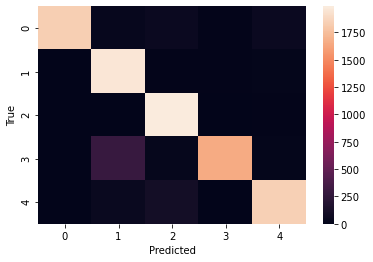

In [156]:
probs = tf.nn.softmax(logits)
predictions = [np.argmax(x) for x in probs.numpy()]

confusion_matrix = tf.math.confusion_matrix(df_test['label_num'], predictions)
sns.heatmap(confusion_matrix.numpy())
plt.xlabel("Predicted")
plt.ylabel("True")